<a href="https://colab.research.google.com/github/douglasmmachado/Battery_SoC/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install nnfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nnfs
from nnfs.datasets import sine_data
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyRegressor
from scipy import stats

In [3]:
def verify_range(df):
  for column in df.columns:
    print(f'Column: {column}\n' +
          f'Max: {df[column].max()} \n' +
          f'Min: {df[column].min()}\n')

In [4]:
df_data = pd.read_csv('https://raw.githubusercontent.com/douglasmmachado/Battery_SoC/main/1%20-%20NN/data.csv')
verify_range(df_data)

#Presence of non valid values for all variables.

Column: current_measured
Max: 1.3708 
Min: -0.54385

Column: voltage_measured
Max: 4.1501 
Min: -30497.0

Column: voc
Max: 4.2 
Min: -2.4903

Column: rint
Max: 0.06135 
Min: 0.06

Column: zeta
Max: 100.0 
Min: -30498.0



In [5]:
#removing values below zero

for column in df_data.columns:

  df_data.drop(df_data[df_data[column] < 0].index, inplace = True)

verify_range(df_data)


Column: current_measured
Max: 1.3708 
Min: 0.63347

Column: voltage_measured
Max: 4.1501 
Min: 3.1217

Column: voc
Max: 4.2 
Min: 3.1779

Column: rint
Max: 0.061266 
Min: 0.06

Column: zeta
Max: 100.0 
Min: 0.054278



In [6]:
#Fill NaN with median
df_data = df_data.fillna(df_data.median())

In [46]:
#Building y and X
I = np.array(df_data['current_measured'])
V = np.array(df_data['voltage_measured'])
Voc = np.array(df_data['voc'])
Rint = np.array(df_data['rint'])
Zeta = np.array(df_data['zeta'])

y = np.stack((Voc, Rint, Zeta), axis=1)
X = np.stack((I, V), axis=1)

In [47]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)

dummy_regr.predict(X)

dummy_regr.score(X, y)


0.0

In [ ]:
#Using MLPRegressor

from sklearn.neural_network import MLPRegressor

'''
hidden_layer_sizes=(100,),
activation='relu', *,
solver='adam',
alpha=0.0001,
batch_size='auto',
learning_rate='constant',
learning_rate_init=0.001,
power_t=0.5,
max_iter=200,
shuffle=True,
random_state=None,
tol=0.0001,
verbose=False,
warm_start=False,
momentum=0.9,
nesterovs_momentum=True,
early_stopping=False,
validation_fraction=0.1,
beta_1=0.9,
beta_2=0.999,
epsilon=1e-08,
n_iter_no_change=10,
max_fun=15000
'''

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(hidden_layer_sizes = 512,
                    activation = 'relu',
                    alpha = 5e-4,
                    learning_rate='adaptive',
                    learning_rate_init = 0.002,
                    random_state=1,
                    max_iter=10000,
                    shuffle = False).fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_test[:1000])

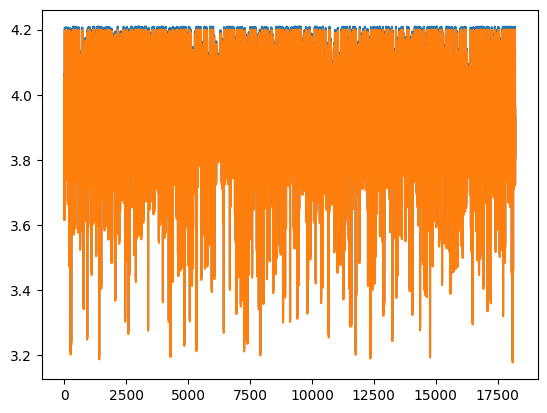

In [53]:
plt.plot(y_pred[:1000,0])
plt.plot(y_test[:1000,0])

In [54]:
regr.score(X_test, y_test)

-0.6333908243880363

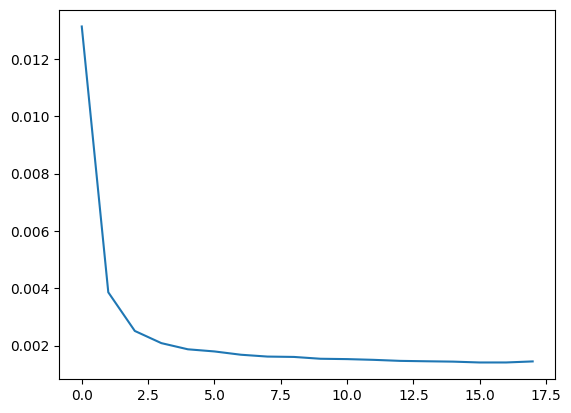

In [29]:
loss = regr.loss_curve_
plt.plot(loss)

In [34]:
#Using TimeSeriesSplit and approach to regression

from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

array([67825, 67826, 67827, 67828, 67829, 67830, 67831, 67832, 67833,
       67834, 67835, 67836, 67837, 67838, 67839, 67840, 67841, 67842,
       67843, 67844, 67845, 67846, 67847, 67848, 67849, 67850, 67851,
       67852, 67853, 67854, 67855, 67856, 67857, 67858, 67859, 67860,
       67861, 67862, 67863, 67864, 67865, 67866, 67867, 67868, 67869,
       67870, 67871, 67872, 67873, 67874, 67875, 67876, 67877, 67878,
       67879, 67880, 67881, 67882, 67883, 67884, 67885, 67886, 67887,
       67888, 67889, 67890, 67891, 67892, 67893, 67894, 67895, 67896,
       67897, 67898, 67899, 67900, 67901, 67902, 67903, 67904, 67905,
       67906, 67907, 67908, 67909, 67910, 67911, 67912, 67913, 67914,
       67915, 67916, 67917, 67918, 67919, 67920, 67921, 67922, 67923,
       67924, 67925, 67926, 67927, 67928, 67929, 67930, 67931, 67932,
       67933, 67934, 67935, 67936, 67937, 67938, 67939, 67940, 67941,
       67942, 67943, 67944, 67945, 67946, 67947, 67948, 67949, 67950,
       67951, 67952,